In [1]:
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib notebook

In [8]:
from scipy.interpolate import interp1d
from copy import deepcopy

In [2]:
def read_data(filename):
    data = {}
    with open(filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            block = row[-1][1:]
            if block.isdigit():
                block = int(block)
            del row[-1]
            del row[0]
            if not block in data:
                data[block] = {}
                data[block]['gyr'] = {}
                data[block]['acc'] = {}
                data[block]['gyr']['x'] = []
                data[block]['gyr']['y'] = []
                data[block]['gyr']['z'] = []
                data[block]['acc']['x'] = []
                data[block]['acc']['y'] = []
                data[block]['acc']['z'] = []
            frow = np.array(map(float, row))
            data[block]['acc']['x'].append(np.array(frow[range(0,len(row),6)]))
            data[block]['acc']['y'].append(np.array(frow[range(1,len(row),6)]))
            data[block]['acc']['z'].append(np.array(frow[range(2,len(row),6)]))
            data[block]['gyr']['x'].append(np.array(frow[range(3,len(row),6)]))
            data[block]['gyr']['y'].append(np.array(frow[range(4,len(row),6)]))
            data[block]['gyr']['z'].append(np.array(frow[range(5,len(row),6)]))
    return data

In [3]:
def inter(obs, ndots=100):
    obs = np.array(obs)
    if ndots == -1:
        return obs
    interpolated = []
    x = np.linspace(0, 100, num=obs.shape[0], endpoint=True)
    f = interp1d(x, obs, kind='slinear')
    xnew = np.linspace(0, 100, num=ndots, endpoint=True)
    interpolated.append(f(xnew))
    return interpolated

In [4]:
def array_from_dict(data, blocks=range(1, 16), ndots=-1, gyro=True, acc=True):
    X = []
    y = []
    for block in data:
        if block in blocks:
            for ind in range(len(data[block]['acc']['x'])):
                y.append(block)
                if gyro and acc:
                    X.append(np.dstack((inter(data[block]['acc']['x'][ind], ndots), 
                                        inter(data[block]['acc']['y'][ind], ndots), 
                                        inter(data[block]['acc']['z'][ind], ndots), 
                                        inter(data[block]['gyr']['x'][ind], ndots), 
                                        inter(data[block]['gyr']['y'][ind], ndots), 
                                        inter(data[block]['gyr']['z'][ind], ndots))))
                if (not gyro) and acc:
                    X.append(np.dstack((inter(data[block]['acc']['x'][ind], ndots), 
                                        inter(data[block]['acc']['y'][ind], ndots), 
                                        inter(data[block]['acc']['z'][ind], ndots))))
                if gyro and (not acc):
                    X.append(np.dstack((inter(data[block]['gyr']['x'][ind], ndots), 
                                        inter(data[block]['gyr']['y'][ind], ndots), 
                                        inter(data[block]['gyr']['z'][ind], ndots))))
    return X, np.array(y)

In [5]:
def integrate(data):
    data_int = deepcopy(data)
    for block in data_int:
        for signal_type in data_int[block]:
            for axis in data_int[block][signal_type]:
                for obs_ind in range(len(data_int[block][signal_type][axis])):
                    data_int[block][signal_type][axis][obs_ind] = np.cumsum(data_int[block][signal_type][axis][obs_ind])
    return data_int

In [98]:
def add_noise(data, var, n):
    data_noise = deepcopy(data)
    for block in data:
        for ind in np.random.choice(range(len(data[block]['acc']['x'])), n):
            obs = np.vstack((data[block]['acc']['x'][ind], data[block]['acc']['y'][ind], 
                             data[block]['acc']['z'][ind], data[block]['gyr']['x'][ind], 
                             data[block]['gyr']['y'][ind], data[block]['gyr']['z'][ind]))
            obs = obs + np.transpose(np.random.multivariate_normal(np.zeros(6), 
                                                                   var*np.identity(6), 
                                                                   len(data[block]['gyr']['z'][ind])))
            data_noise[block]['acc']['x'].append(obs[0])
            data_noise[block]['acc']['y'].append(obs[1])
            data_noise[block]['acc']['z'].append(obs[2])
            data_noise[block]['gyr']['x'].append(obs[3])
            data_noise[block]['gyr']['y'].append(obs[4])
            data_noise[block]['gyr']['z'].append(obs[5])
            
    return data_noise

In [90]:
data1 = read_data('data1.csv') # Your data
data2 = read_data('data2.csv') # My data (I dont have a gyroscope)
data3 = read_data('data3.csv') # 
data4 = read_data('data4.csv') # 

In [108]:
ndata1 = add_noise(data1, 0.5, 100) #  +100 obs to each class
ndata1i = integrate(ndata1)
ndata1ii = integrate(ndata1i)

ndata2 = add_noise(data2, 0.5, 100) #  +100 obs to each class
ndata2i = integrate(ndata2)
ndata2ii = integrate(ndata2i)

ndata3 = add_noise(data3, 0.5, 100) #  +100 obs to each class
ndata3i = integrate(ndata3)
ndata3ii = integrate(ndata3i)

ndata4 = add_noise(data4, 0.5, 100) #  +100 obs to each class
ndata4i = integrate(ndata4)
ndata4ii = integrate(ndata4i)

In [9]:
data1i = integrate(data1)
data1ii = integrate(data1i)
data2i = integrate(data2)
data2ii = integrate(data2i)
data3i = integrate(data3)
data3ii = integrate(data3i)
data4i = integrate(data4)
data4ii = integrate(data4i)

In [10]:
def plot_block_gest(data, n_block):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111,projection='3d')
    counter = 0
    color_map = {0: 'r', 1: 'b'}
    for block in n_block:
        c = color_map[counter]
        counter += 1
        for ind in range(len(data[block]['acc']['x'])):
            ax.plot(data[block]['acc']['x'][ind], data[block]['acc']['y'][ind], data[block]['acc']['z'][ind], c)
    plt.show()

<IPython.core.display.Javascript object>


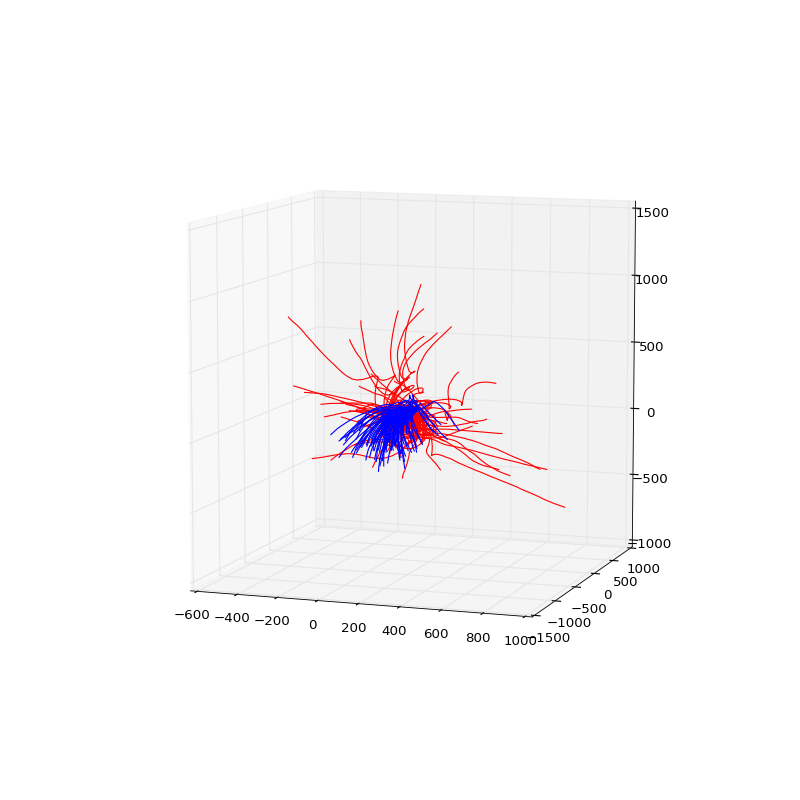

In [109]:
plot_block_gest(ndata1ii, [1, 9]) # 1 and 9 classes

<IPython.core.display.Javascript object>


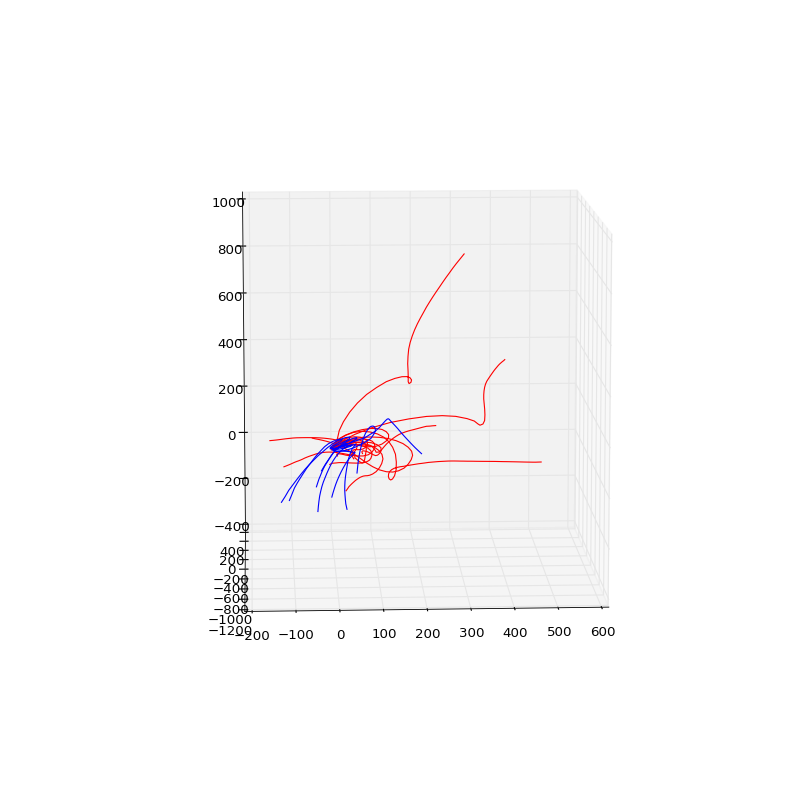

In [103]:
plot_block_gest(data1ii, [1, 9])

<IPython.core.display.Javascript object>


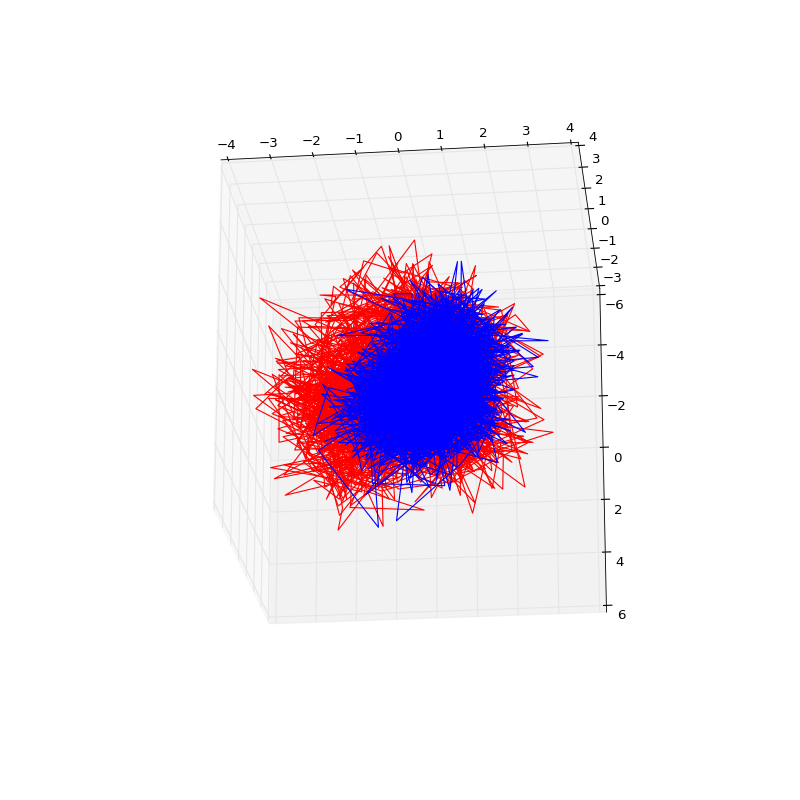

In [110]:
plot_block_gest(ndata2, [1, 9])

<IPython.core.display.Javascript object>


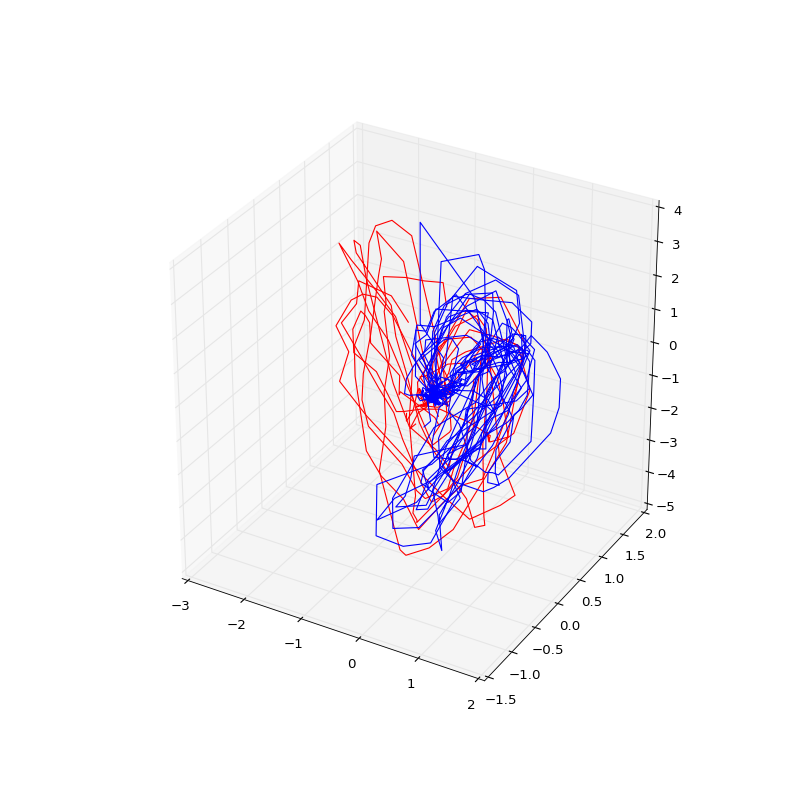

In [38]:
plot_block_gest(data2, [1, 9])